## Import

In [1]:
import sys; sys.path.insert(0, '..')
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
sys.path.insert(1, '../utils')
from utils.df_utils import df_wrapper
from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from utils.declarations import training_files, testing_files, POSE_MAP

## Define data

In [2]:
testing_file = testing_files["Xiaomeng"]
AMOUNT_OF_SENSORS = 3

## Datapreparation

### Train

In [3]:
knn_train = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    print(elem.df.shape)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(training_files[key].annot_file, POSE_MAP)
    knn_train.append(elem)

y_train = pd.concat([x.df['Pose'] for x in knn_train])

(162296, 26)
(160665, 26)
(165066, 26)
(249084, 26)
(243683, 26)
(248392, 26)
(49005, 26)
(49041, 26)


### Test

In [4]:
knn_test = df_wrapper(testing_file.csv_file)
knn_test.concat_sensor_data(AMOUNT_OF_SENSORS)
knn_test.align_poses(testing_file.annot_file, POSE_MAP)
y_test = knn_test.df["Pose"]
y_test.index = [i for i in range(len(y_test))]

## Visualisation

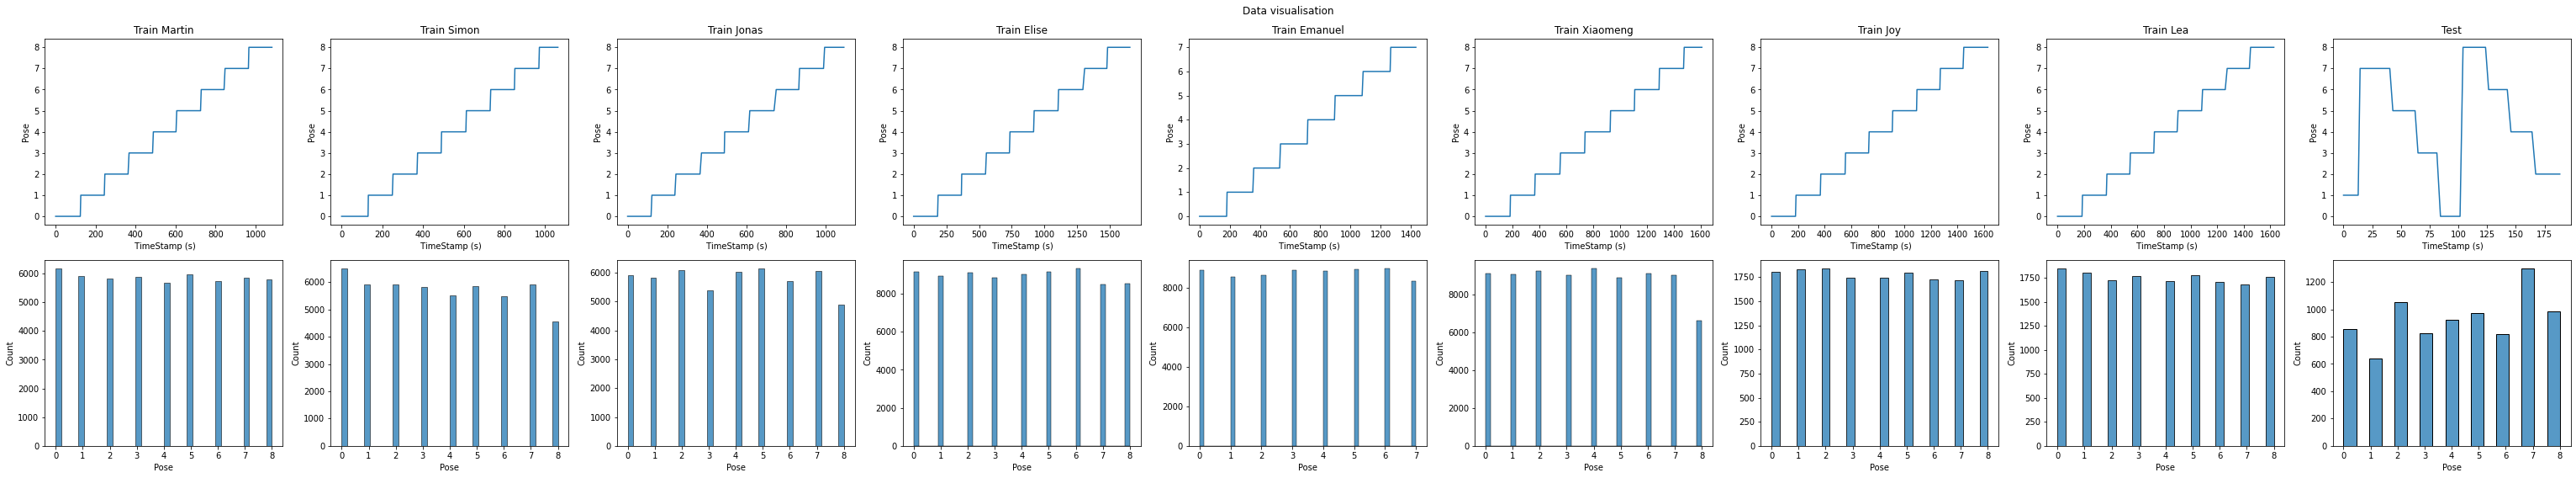

In [5]:
cols = []
height=8
width=(height/1.5)*len(knn_train)
fig, axes = plt.subplots(2, len(knn_train)+1, figsize=(width, height))
fig.suptitle('Data visualisation')
for i in range(len(knn_train)):
    sns.lineplot(ax=axes[0, i], data=knn_train[i].df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=knn_train[i].df["Pose"])
    cols.append('Train')    
for i, key in enumerate(training_files):
    cols[i] += f' {key}'
sns.lineplot(ax=axes[0, len(knn_train)], data=knn_test.df, x=" TimeStamp (s)", y='Pose')
sns.histplot(ax=axes[1, len(knn_train)], data=y_test)
cols.append('Test')
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

In [20]:
x_train = pd.concat([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in knn_train])
x_test = knn_test.df.drop([' TimeStamp (s)', 'Pose'], axis=1) 
x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [23]:
print(x_train_numpy.shape)

(418127, 39)


## Adjust dataframes

## Add scaler

In [16]:



print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

arr_3d_x_train = []
temp_2d_x_train = []

arr_2d_y_train = []
temp_y_train = []


NUM_TIMESTAMPS = 20
NUM_FEATURES = 26

mode_arr = []

for i in range(1,len(x_train_numpy)):
    temp_2d_x_train.append(x_train_numpy[0])
    temp_y_train.append(y_train_numpy[i])
    if i % NUM_TIMESTAMPS == 0:
        mode_arr.append(temp_y_train)
        arr_3d_x_train.append(temp_2d_x_train)

        temp_y_train = []
        temp_2d_x_train = []
    
print("arr_3d_x_train: ", np.shape(arr_3d_x_train))
print("mode_arr: ", np.shape(mode_arr))




(418127, 39)
(20906, 9)
(8367, 39)
(8367,)
arr_3d_x_train:  (20906, 20, 39)
mode_arr:  (20906, 20)


In [8]:
from scipy import stats

y_train_to_be_encoded = []

for i in range(len(mode_arr)):
    mode = stats.mode(mode_arr[i])
    y_train_to_be_encoded.append(mode.mode[0])

print(np.shape(y_train_to_be_encoded))


(20906,)


In [9]:
def one_hot_encode(sequence):
    encoding = []
    for value in sequence:
        vector = [0 for _ in range(9)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

In [10]:
#scaler = MinMaxScaler()
#scaler.fit(x_train_numpy)
#x_train_numpy = scaler.transform(arr_3d_x_train)
#x_test_numpy = scaler.transform(arr_2d_y_train)

y_train = one_hot_encode(y_train_to_be_encoded)
#y_test = to_categorical(y_test_numpy,9)
print(np.shape(y_train))

(20906, 9)


## Hyperparams

In [57]:
EPOCH = 20
BATCH_SIZE = 10000
LR = 0.5
DROPOUT_RATE1 = 0.4
DROPOUT_RATE2 = 0.4
ACTIVATION1 = 'relu'
ACTIVATION2 = 'softmax'
OPTIM = Adam(learning_rate=LR)
#OPTIM = RMSPROP(learning_rate=LR)

## Model

In [105]:
from keras.layers import LSTM
from tensorflow.keras import layers

model = Sequential()
model.add(layers.LSTM(9, stateful=True, batch_input_shape=(1,20,39),input_shape=[np.array(arr_3d_x_train).shape[1], np.array(arr_3d_x_train).shape[2]]))
model.add(Dropout(rate=0.5))
model.add(Dense(9, activation='softmax'))

model.compile(optimizer=OPTIM, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

## Fit the model

In [106]:

#model.fit(x=np.array(arr_3d_x_train), batch_size=512, y=y_train, shuffle=False, epochs=10)


model.fit(x=np.array(arr_3d_x_train), batch_size=1, y=y_train, epochs=3, shuffle=False)
#model.reset_states()



Epoch 1/3
20906/20906 [==============================] - 88s 4ms/step - loss: 6.4995 - accuracy: 0.9519
Epoch 2/3
20906/20906 [==============================] - 89s 4ms/step - loss: 6.4615 - accuracy: 0.9467
Epoch 3/3
20906/20906 [==============================] - 90s 4ms/step - loss: 6.3128 - accuracy: 0.9479


## Visualise the loss

<AxesSubplot:>

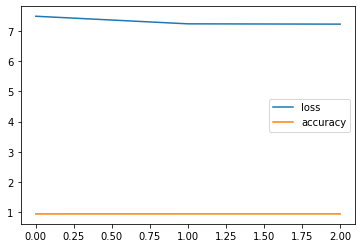

In [107]:
history = pd.DataFrame(model.history.history)
history.plot()

## Predict

In [82]:
predictions = model.predict(x_test_numpy)
predictions_final = []  
y_test_arr = []
for index in range(len(predictions)):
    predictions_final.append(predictions[index].argmax())
    y_test_arr.append(y_test[index].argmax())

number_of_corrects = 0
for i in range(len(predictions_final)):
    if(predictions_final[i] == y_test_arr[i]):
        number_of_corrects += 1
print(number_of_corrects)
print("% of corrects: {}".format(number_of_corrects/len(predictions_final)*100))

ValueError: in user code:

    C:\Users\simon\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\simon\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\simon\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\simon\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\simon\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\simon\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\simon\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\simon\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\simon\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_15 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 39)


## Visualise prediction

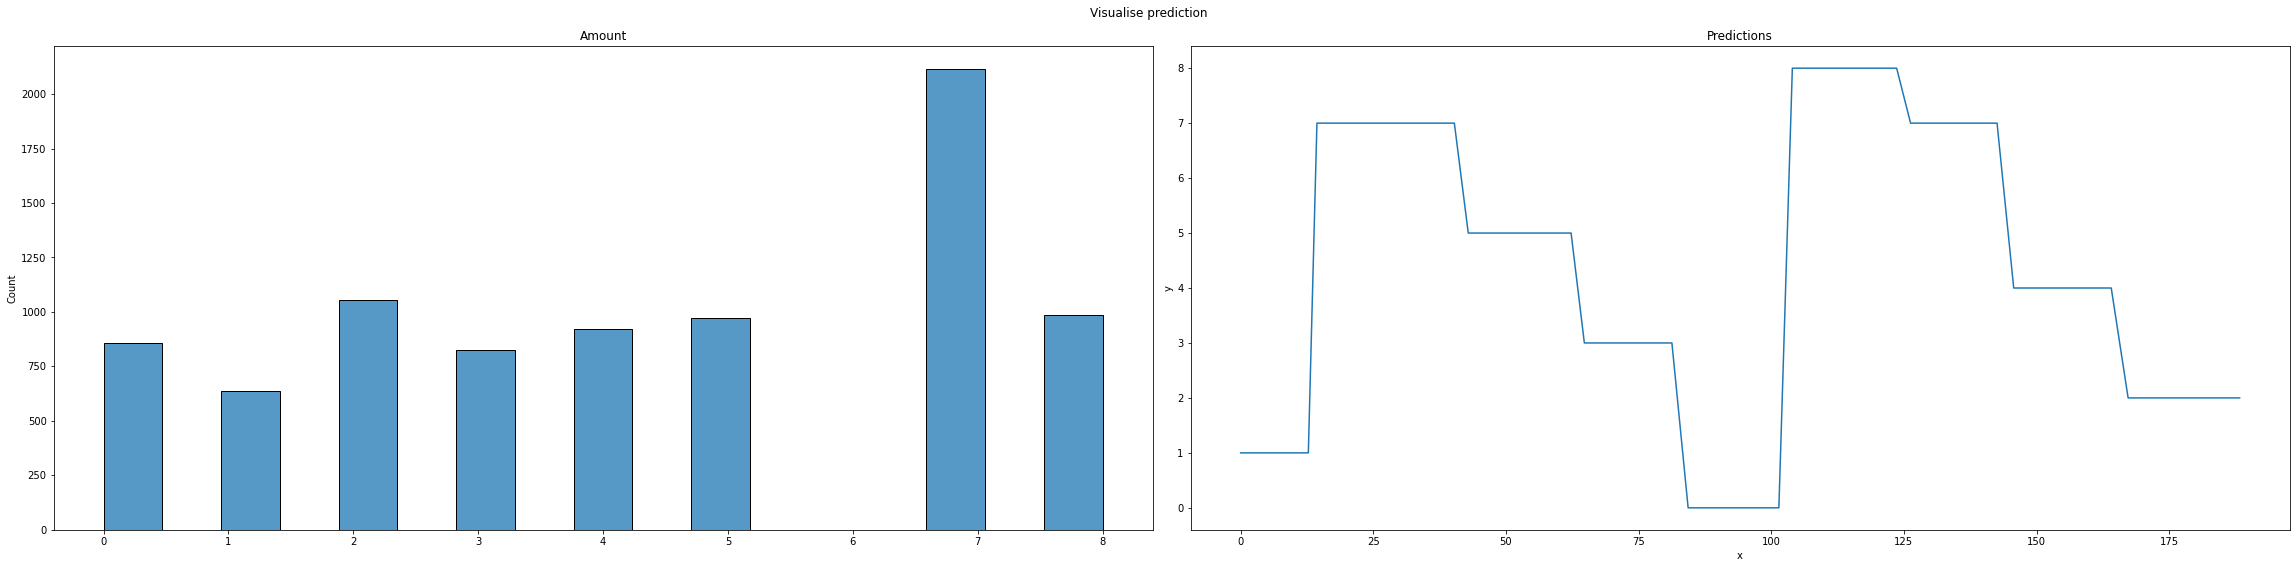

In [ ]:
df_predict = pd.DataFrame({'x': knn_test.df[' TimeStamp (s)'],'y':predictions_final})

fig, axes = plt.subplots(1, 2, figsize=(width, height))
sns.histplot(ax=axes[0], data=predictions_final)
sns.lineplot(ax=axes[1], data=df_predict,x='x',y='y')
fig.suptitle('Visualise prediction')
cols = ['Amount', 'Predictions']
for ax, col in zip(axes, cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

In [ ]:
model.save(f"../models/LSTM_model_{AMOUNT_OF_SENSORS}.h5")

INFO:tensorflow:Assets written to: ../../ANN_model/assets


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>